In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
import requests
import torch.nn as nn
import torch.optim as optim
import random
!pip install datasets

from nltk.tokenize import sent_tokenize, word_tokenize
from datasets import load_dataset
import nltk
nltk.download('punkt')

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
dataset = load_dataset('cnn_dailymail', '3.0.0', split="train[:1500]") 

train_data = dataset
val_data = load_dataset('cnn_dailymail', '3.0.0', split="validation[:500]") 
test_data = load_dataset('cnn_dailymail', '3.0.0', split="test[:500]") 

def preprocess_text(text):
    sentences = sent_tokenize(text)
    tokenized_sentences = [word_tokenize(sent) for sent in sentences]
    return tokenized_sentences

train_summaries = [example['highlights'] for example in train_data]
train_texts = [example['article'] for example in train_data]

val_summaries = [example['highlights'] for example in val_data]
val_texts = [example['article'] for example in val_data]

test_summaries = [example['highlights'] for example in test_data]
test_texts = [example['article'] for example in test_data]

In [4]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import Counter
import torch.nn.utils.rnn as rnn_utils
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

def build_vocab(texts):
    vocab = {}
    word_counter = Counter(word for text in texts for word in nltk.word_tokenize(text))
    for word, count in word_counter.items():
        vocab[word] = len(vocab)
    return vocab

def sentence_to_sequence(sentence, vocab):
    return [vocab[word] for word in sentence if word in vocab]

def pad_sequence(sequence, max_length):
    return sequence[:max_length] + [0] * max(0, max_length - len(sequence))

class CustomDataset(Dataset):
    def __init__(self, sequences_input, sequences_target, max_length):
        self.sequences_input = sequences_input
        self.sequences_target = sequences_target
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences_input)

    def __getitem__(self, index):
        input_sequence = self.sequences_input[index]
        target_summary = self.sequences_target[index]

        input_sequence = pad_sequence(input_sequence, self.max_length)
        target_summary = pad_sequence(target_summary, self.max_length)

        input_tensor = torch.tensor(input_sequence, dtype=torch.long)
        target_tensor = torch.tensor(target_summary, dtype=torch.long)

        return input_tensor, target_tensor

class GRUModel(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        prediction = self.fc_out(outputs)
        return prediction

vocab_input = build_vocab(train_texts)
vocab_target = build_vocab(train_summaries)

train_sequences_input = [sentence_to_sequence(text, vocab_input) for text in train_texts]
val_sequences_input = [sentence_to_sequence(text, vocab_input) for text in val_texts]
test_sequences_input = [sentence_to_sequence(text, vocab_input) for text in test_texts]

train_sequences_target = [sentence_to_sequence(summary, vocab_target) for summary in train_summaries]
val_sequences_target = [sentence_to_sequence(summary, vocab_target) for summary in val_summaries]
test_sequences_target = [sentence_to_sequence(summary, vocab_target) for summary in test_summaries]

max_length = 128

train_padded_input = rnn_utils.pad_sequence([torch.tensor(seq) for seq in train_sequences_input], batch_first=True, padding_value=0)
val_padded_input = rnn_utils.pad_sequence([torch.tensor(seq) for seq in val_sequences_input], batch_first=True, padding_value=0)
test_padded_input = rnn_utils.pad_sequence([torch.tensor(seq) for seq in test_sequences_input], batch_first=True, padding_value=0)

train_padded_target = rnn_utils.pad_sequence([torch.tensor(seq) for seq in train_sequences_target], batch_first=True, padding_value=0)
val_padded_target = rnn_utils.pad_sequence([torch.tensor(seq) for seq in val_sequences_target], batch_first=True, padding_value=0)
test_padded_target = rnn_utils.pad_sequence([torch.tensor(seq) for seq in test_sequences_target], batch_first=True, padding_value=0)

encoder_input_dim = len(vocab_input)
decoder_output_dim = len(vocab_target)
embedding_dim = 100
hidden_dim = 256
num_layers = 2
dropout = 0.5

batch_size = 32

train_dataset = CustomDataset(train_sequences_input, train_sequences_target, max_length)
val_dataset = CustomDataset(val_sequences_input, val_sequences_target, max_length)
test_dataset = CustomDataset(test_sequences_input, test_sequences_target, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
gru_model = GRUModel(encoder_input_dim, embedding_dim, hidden_dim, num_layers, dropout).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_model.parameters())

Epochs: 10

In [6]:
l1=[]
l2=[]
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_inputs, batch_targets in dataloader:
        torch.cuda.empty_cache()
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        torch.cuda.empty_cache()
        outputs = outputs.view(-1, outputs.size(2))
        batch_targets = batch_targets.view(-1)
        loss = criterion(outputs, batch_targets)
        torch.cuda.empty_cache()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        torch.cuda.empty_cache()
    l1.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


def validate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            torch.cuda.empty_cache()
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            torch.cuda.empty_cache()
            outputs = outputs.view(-1, outputs.size(2))
            batch_targets = batch_targets.view(-1)
            loss = criterion(outputs, batch_targets)
            total_loss += loss.item()
            torch.cuda.empty_cache()
    l2.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_model(gru_model, train_loader, criterion, optimizer, device)
    validation_loss = validate_model(gru_model, val_loader, criterion, device)
    torch.cuda.empty_cache()
    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Validation Loss: {validation_loss:.4f}")

Epoch [1/10] Train Loss: 2.4951 Validation Loss: 0.7603
Epoch [2/10] Train Loss: 0.8630 Validation Loss: 0.5859
Epoch [3/10] Train Loss: 0.7344 Validation Loss: 0.6790
Epoch [4/10] Train Loss: 0.7084 Validation Loss: 0.5842
Epoch [5/10] Train Loss: 0.6958 Validation Loss: 0.5735
Epoch [6/10] Train Loss: 0.6925 Validation Loss: 0.5617
Epoch [7/10] Train Loss: 0.6852 Validation Loss: 0.6149
Epoch [8/10] Train Loss: 0.6901 Validation Loss: 0.6228
Epoch [9/10] Train Loss: 0.6817 Validation Loss: 0.5729
Epoch [10/10] Train Loss: 0.6828 Validation Loss: 0.6206


In [8]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs, 2)
            total_correct += (predicted == batch_targets).sum().item()
            total_samples += batch_targets.numel()

    accuracy = total_correct / total_samples
    return accuracy

accuracy = evaluate_model(gru_model, test_loader, device)
print(f"Test Accuracy: {accuracy*100:.6f}")

Test Accuracy: 83.653125


In [10]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs, 2)
            total_correct += (predicted == batch_targets).sum().item()
            total_samples += batch_targets.numel()

    accuracy = total_correct / total_samples
    return accuracy

accuracy = evaluate_model(gru_model, val_loader, device)
print(f"Validation Accuracy: {accuracy*100:.6f}")

Validation Accuracy: 83.360938


In [12]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs, 2)
            total_correct += (predicted == batch_targets).sum().item()
            total_samples += batch_targets.numel()

    accuracy = total_correct / total_samples
    return accuracy

accuracy = evaluate_model(gru_model, train_loader, device)
print(f"Train Accuracy: {accuracy*100:.6f}")

Train Accuracy: 82.895833


In [13]:
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'GRU MODEL')

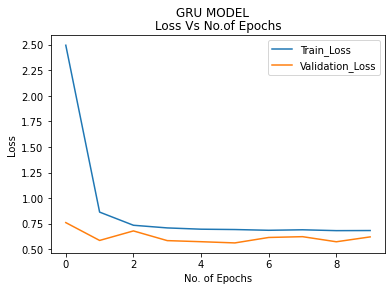

In [14]:
plt.plot(l1, label = "Train_Loss")
plt.plot(l2, label = "Validation_Loss")
plt.title("Loss Vs No.of Epochs")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.suptitle("GRU MODEL")

Epochs: 15

In [15]:
l3=[]
l4=[]
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_inputs, batch_targets in dataloader:
        torch.cuda.empty_cache()
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        torch.cuda.empty_cache()
        outputs = outputs.view(-1, outputs.size(2))
        batch_targets = batch_targets.view(-1)
        loss = criterion(outputs, batch_targets)
        torch.cuda.empty_cache()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        torch.cuda.empty_cache()
    l3.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


def validate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            torch.cuda.empty_cache()
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            torch.cuda.empty_cache()
            outputs = outputs.view(-1, outputs.size(2))
            batch_targets = batch_targets.view(-1)
            loss = criterion(outputs, batch_targets)
            total_loss += loss.item()
            torch.cuda.empty_cache()
    l4.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


num_epochs = 15
for epoch in range(num_epochs):
    train_loss = train_model(gru_model, train_loader, criterion, optimizer, device)
    validation_loss = validate_model(gru_model, val_loader, criterion, device)
    torch.cuda.empty_cache()
    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Validation Loss: {validation_loss:.4f}")

Epoch [1/15] Train Loss: 0.6793 Validation Loss: 0.5585
Epoch [2/15] Train Loss: 0.6814 Validation Loss: 0.6478
Epoch [3/15] Train Loss: 0.6769 Validation Loss: 0.6560
Epoch [4/15] Train Loss: 0.6744 Validation Loss: 0.6119
Epoch [5/15] Train Loss: 0.6801 Validation Loss: 0.6376
Epoch [6/15] Train Loss: 0.6739 Validation Loss: 0.5457
Epoch [7/15] Train Loss: 0.6745 Validation Loss: 0.6076
Epoch [8/15] Train Loss: 0.6770 Validation Loss: 0.6298
Epoch [9/15] Train Loss: 0.6732 Validation Loss: 0.6116
Epoch [10/15] Train Loss: 0.6698 Validation Loss: 0.6287
Epoch [11/15] Train Loss: 0.6708 Validation Loss: 0.6066
Epoch [12/15] Train Loss: 0.6685 Validation Loss: 0.6397
Epoch [13/15] Train Loss: 0.6685 Validation Loss: 0.6040
Epoch [14/15] Train Loss: 0.6705 Validation Loss: 0.6540
Epoch [15/15] Train Loss: 0.6769 Validation Loss: 0.6578


Text(0.5, 0.98, 'GRU MODEL')

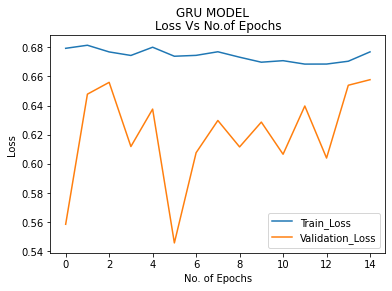

In [16]:
plt.plot(l3, label = "Train_Loss")
plt.plot(l4, label = "Validation_Loss")
plt.title("Loss Vs No.of Epochs")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.suptitle("GRU MODEL")

Epochs: 20

In [17]:
l5=[]
l6=[]
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_inputs, batch_targets in dataloader:
        torch.cuda.empty_cache()
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        torch.cuda.empty_cache()
        outputs = outputs.view(-1, outputs.size(2))
        batch_targets = batch_targets.view(-1)
        loss = criterion(outputs, batch_targets)
        torch.cuda.empty_cache()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        torch.cuda.empty_cache()
    l5.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


def validate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            torch.cuda.empty_cache()
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            torch.cuda.empty_cache()
            outputs = outputs.view(-1, outputs.size(2))
            batch_targets = batch_targets.view(-1)
            loss = criterion(outputs, batch_targets)
            total_loss += loss.item()
            torch.cuda.empty_cache()
    l6.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_model(gru_model, train_loader, criterion, optimizer, device)
    validation_loss = validate_model(gru_model, val_loader, criterion, device)
    torch.cuda.empty_cache()
    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Validation Loss: {validation_loss:.4f}")

Epoch [1/20] Train Loss: 0.6740 Validation Loss: 0.5907
Epoch [2/20] Train Loss: 0.6702 Validation Loss: 0.5889
Epoch [3/20] Train Loss: 0.6681 Validation Loss: 0.6368
Epoch [4/20] Train Loss: 0.6697 Validation Loss: 0.6272
Epoch [5/20] Train Loss: 0.6730 Validation Loss: 0.6923
Epoch [6/20] Train Loss: 0.6718 Validation Loss: 0.6123
Epoch [7/20] Train Loss: 0.6691 Validation Loss: 0.6031
Epoch [8/20] Train Loss: 0.6694 Validation Loss: 0.6171
Epoch [9/20] Train Loss: 0.6676 Validation Loss: 0.6378
Epoch [10/20] Train Loss: 0.6659 Validation Loss: 0.6109
Epoch [11/20] Train Loss: 0.6681 Validation Loss: 0.5908
Epoch [12/20] Train Loss: 0.6668 Validation Loss: 0.6282
Epoch [13/20] Train Loss: 0.6643 Validation Loss: 0.6368
Epoch [14/20] Train Loss: 0.6654 Validation Loss: 0.5740
Epoch [15/20] Train Loss: 0.6681 Validation Loss: 0.6276
Epoch [16/20] Train Loss: 0.6637 Validation Loss: 0.6377
Epoch [17/20] Train Loss: 0.6638 Validation Loss: 0.6094
Epoch [18/20] Train Loss: 0.6662 Validat

Text(0.5, 0.98, 'GRU MODEL')

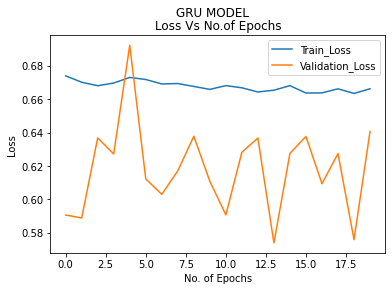

In [18]:
plt.plot(l5, label = "Train_Loss")
plt.plot(l6, label = "Validation_Loss")
plt.title("Loss Vs No.of Epochs")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.suptitle("GRU MODEL")

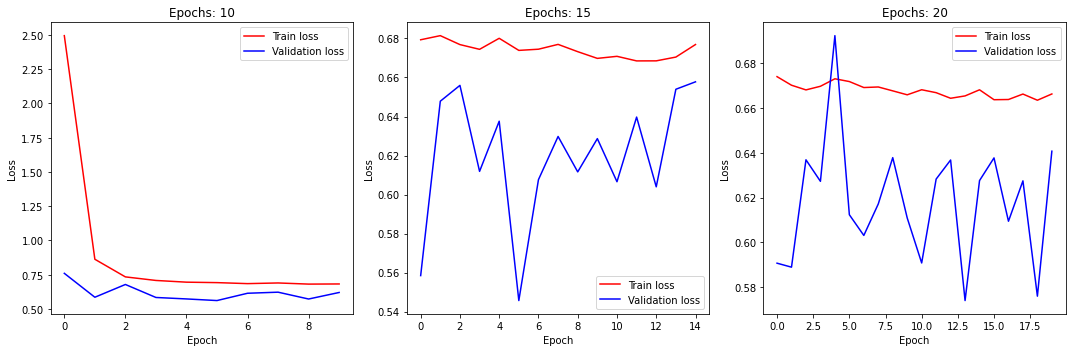

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(l1, label='Train loss', color='red')
axes[0].plot(l2, label='Validation loss', color='blue')
axes[0].set_title('Epochs: 10')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(l3, label='Train loss', color='red')
axes[1].plot(l4, label='Validation loss', color='blue')
axes[1].set_title('Epochs: 15')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

axes[2].plot(l5, label='Train loss', color='red')
axes[2].plot(l6, label='Validation loss', color='blue')
axes[2].set_title('Epochs: 20')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()

plt.tight_layout()

plt.show()